In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from autograd import grad, jacobian
from src.helpers import *

Bad value in file 'matplotlibrc', line 55 ("axes.prop_cycle: cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])"): Key axes.prop_cycle: "cycler('color', ['" is not a valid cycler construction: unterminated string literal (detected at line 1) (<unknown>, line 1)


### First Example:
For simplicitly we reduce to a 1d case without time dependendence of the parameters. 

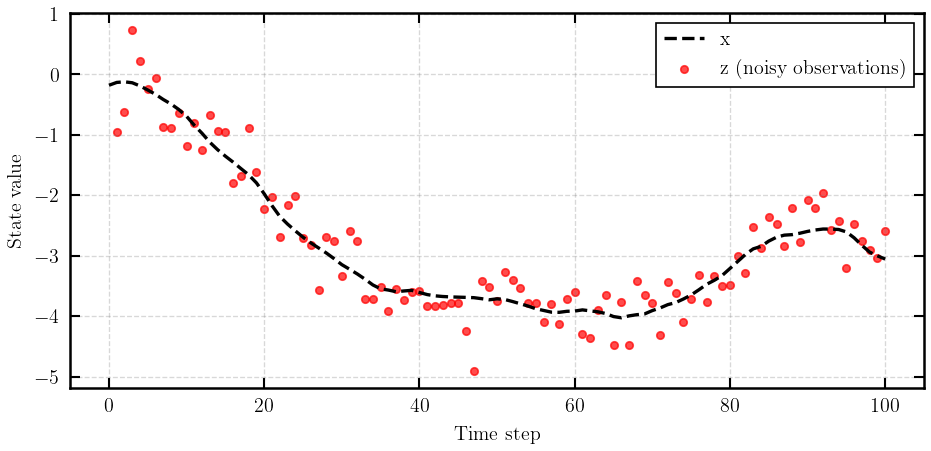

In [2]:
h = 0.1
sigma = 0.33
mu_0 = np.zeros(2)
Sigma_0 = np.eye(2)*0.33

A = np.array([[1, h], [0, 1]])
Q = np.array([[h**3/3, h**2/2], [h**2/2, h]])
H = np.array([[1, 0]])
R = np.array([[sigma]])

#Sample a true process
np.random.seed(6)
x_0 = np.random.multivariate_normal(mu_0, Sigma_0)
x_sequence = [x_0]
z_sequence = []
for i in range(100):
    x_sequence.append(np.random.multivariate_normal(A @ x_sequence[-1], Q))
    z_sequence.append(np.random.normal(H @ x_sequence[-1], R))
x_sequence = np.array(x_sequence)
z_sequence = np.array(z_sequence).reshape(-1,1)


plt.figure(figsize=(8, 4))
plt.plot(x_sequence[:, 0], label='x', color='black', linestyle='--')
#plt.plot(x_sequence[:, 1], label='x[1] (velocity)')
plt.scatter(range(1,len(z_sequence)+1), z_sequence, color='red', s=20, alpha=0.7, label='z (noisy observations)')
plt.xlabel('Time step')
plt.ylabel('State value')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
ts = np.arange(101)

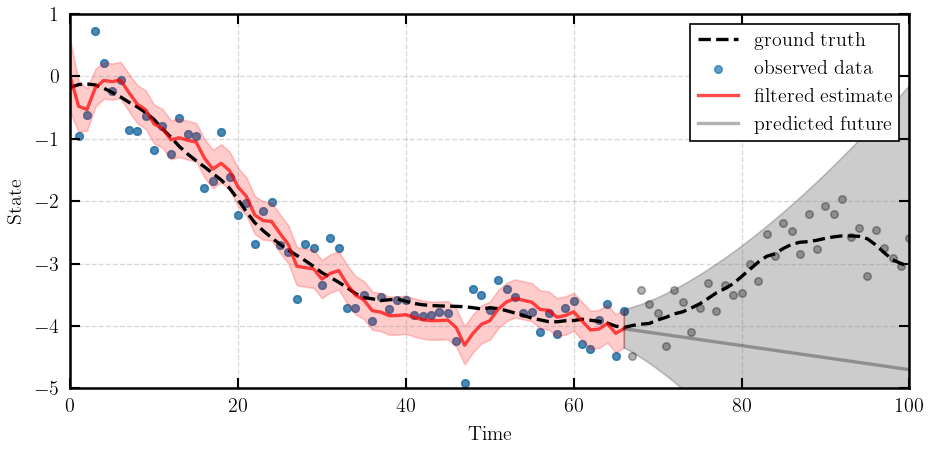

In [4]:
t=66
m_projected, P_projected, m_future_projected, P_future_projected = kalman_filter(t, 101, mu_0, Sigma_0, A, Q, H, R, z_sequence)
plot_kalman_filter(t, ts, m_projected, P_projected, m_future_projected, P_future_projected, x_sequence=x_sequence[:,0], z_sequence=z_sequence, x_lim=[0,100], y_lim=[-5,1])

In [5]:
for t in tqdm(range(101)):
    m_projected, P_projected, m_future_projected, P_future_projected = kalman_filter(t, 101, mu_0, Sigma_0, A, Q, H, R, z_sequence)
    plot_kalman_filter(t, ts, m_projected, P_projected, m_future_projected, P_future_projected, x_sequence[:,0], z_sequence, savefig=True)

100%|██████████| 101/101 [00:16<00:00,  6.22it/s]


### Smoothing Procedure

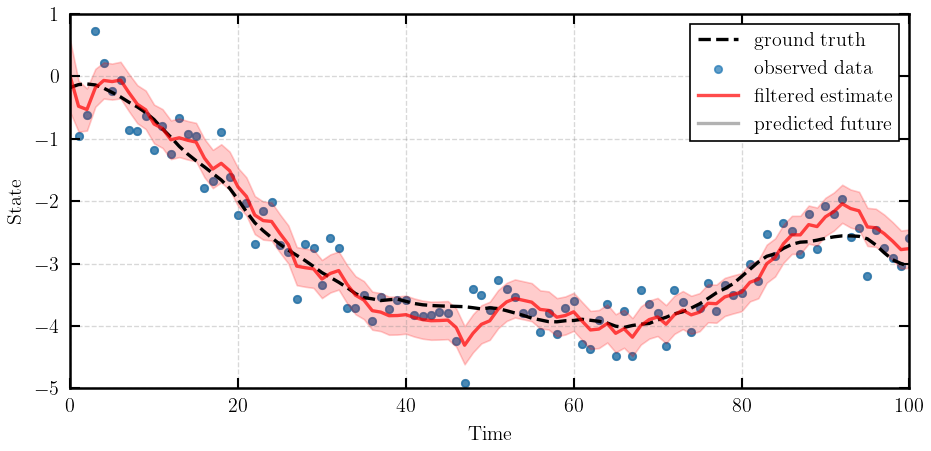

In [5]:
t=100
m_projected, P_projected, m_future_projected, P_future_projected = kalman_filter(t, 101, mu_0, Sigma_0, A, Q, H, R, z_sequence)
plot_kalman_filter(t, ts, m_projected, P_projected, m_future_projected, P_future_projected, x_sequence=x_sequence[:,0], z_sequence=z_sequence, x_lim=[0,100], y_lim=[-5,1])

In [6]:
(m_seq, P_seq,
 m_smooth, P_smooth,
 m_proj, P_proj,
 m_smooth_proj, P_smooth_proj) = kalman_smoother_full(
    mu_0, Sigma_0, A, Q, H, R, z_sequence)


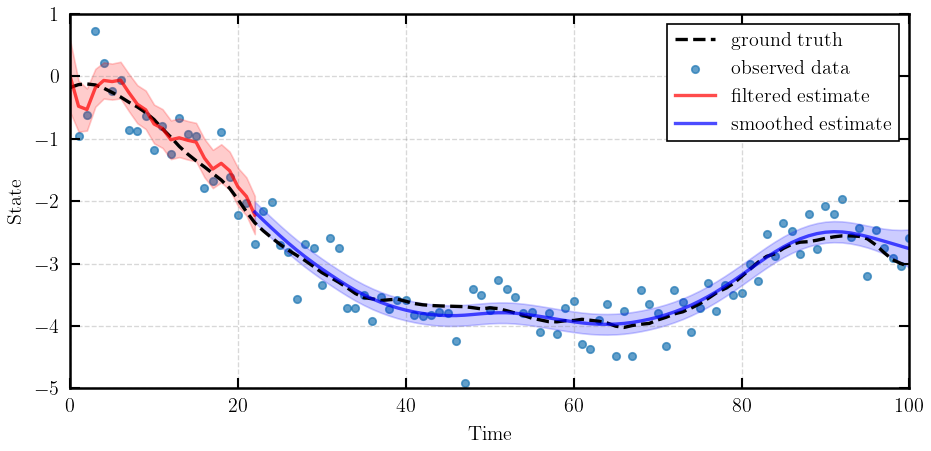

In [ ]:
plot_smoothed_estimate(
    22, ts, x_sequence[:,0], z_sequence,
    m_proj, P_proj,
    m_smooth_proj, P_smooth_proj,
    x_lim=[0, 100], y_lim=[-5, 1], savefig=False
)

In [ ]:
for t in tqdm(range(101)):
    plot_smoothed_estimate(
    t, ts, x_sequence[:,0], z_sequence,
    m_proj, P_proj,
    m_smooth_proj, P_smooth_proj,
    x_lim=[0, 100], y_lim=[-5, 1], savefig=True
)

### EKF0

### EKF1


In [14]:
#define a nonlinear observation function
g = lambda x: x[0] + 0.3 * np.sin(5*x[0]) - 0.1  + 0.1*x[1]**3

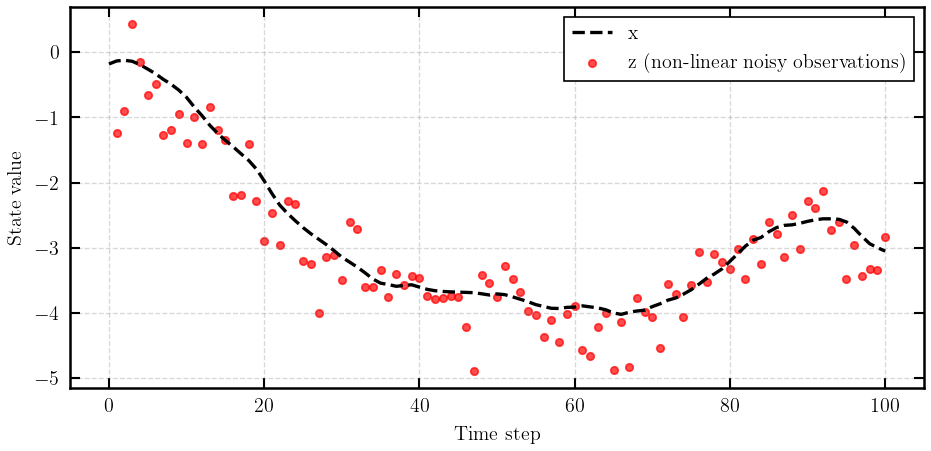

In [15]:
h = 0.1
sigma = 0.33
mu_0 = np.zeros(2)
Sigma_0 = np.eye(2)*0.33

A = np.array([[1, h], [0, 1]])
Q = np.array([[h**3/3, h**2/2], [h**2/2, h]])
H = np.array([[1, 0]])
R = np.array([[sigma]])

#Sample a true process
np.random.seed(6)
x_0 = np.random.multivariate_normal(mu_0, Sigma_0)
x_sequence = [x_0]
z_sequence = []
for i in range(100):
    x_sequence.append(np.random.multivariate_normal(A @ x_sequence[-1], Q))
    z_sequence.append(np.random.normal(g(x_sequence[-1]), R))
x_sequence = np.array(x_sequence)
z_sequence = np.array(z_sequence).reshape(-1,1)

# get the nonlinear observation


plt.figure(figsize=(8, 4))
plt.plot(x_sequence[:, 0], label='x', color='black', linestyle='--')
#plt.plot(x_sequence[:, 1], label='x[1] (velocity)')
plt.scatter(range(1,len(z_sequence)+1), z_sequence, color='red', s=20, alpha=0.7, label='z (non-linear noisy observations)')
plt.xlabel('Time step')
plt.ylabel('State value')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
#Autodiff jacobian 
jacobian_g = jacobian(g)
x0 = np.array(x_sequence[0])
J = jacobian_g(x0)
print(J)

[1.93765733 0.05261323]


In [17]:
z_sequence.shape

(100, 1)

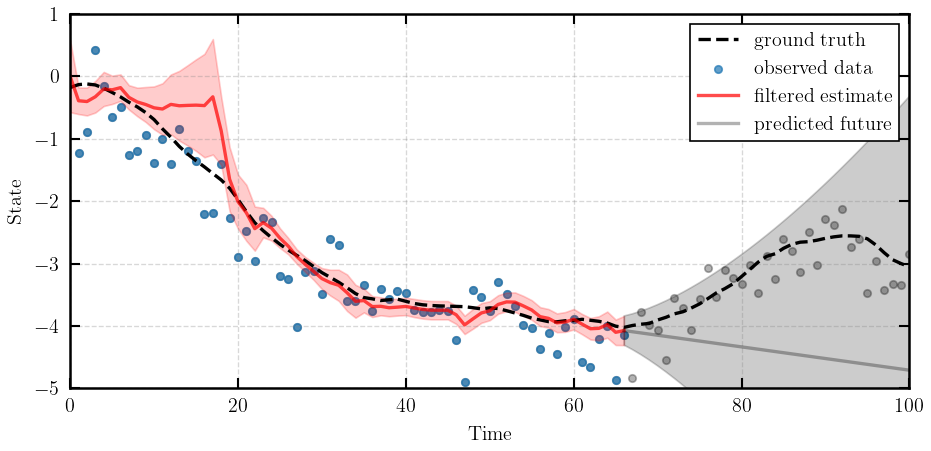

In [18]:
t = 66
m_projected, P_projected, m_future_projected, P_future_projected = extended_kalman_filter(t, 101, mu_0, Sigma_0, A, Q, R, z_sequence, g, jacobian_g)
plot_kalman_filter(t, ts, m_projected, P_projected, m_future_projected, P_future_projected, x_sequence=x_sequence[:,0], z_sequence=z_sequence, x_lim=[0,100], y_lim=[-5,1])


In [12]:
for t in tqdm(range(101)):
    m_projected, P_projected, m_future_projected, P_future_projected = extended_kalman_filter(t, 101, mu_0, Sigma_0, A, Q, R, z_sequence, g, jacobian_g)
    plot_kalman_filter(t, ts, m_projected, P_projected, m_future_projected, P_future_projected, x_sequence[:,0], z_sequence, savefig=True)

100%|██████████| 101/101 [00:16<00:00,  6.07it/s]


#### Smoothing


In [19]:
(m_seq, P_seq,
 m_smooth, P_smooth,
 m_proj, P_proj,
 m_smooth_proj, P_smooth_proj) = extended_kalman_smoother_full(
    mu_0, Sigma_0, A, Q, R, z_sequence, g, jacobian_g, projection_index=0
)

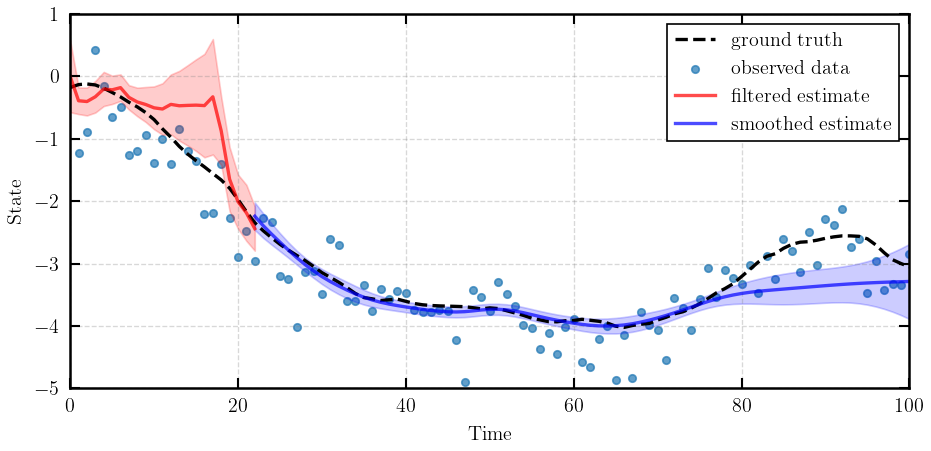

In [20]:
plot_smoothed_estimate(
    22, ts, x_sequence[:,0], z_sequence,
    m_proj, P_proj,
    m_smooth_proj, P_smooth_proj,
    x_lim=[0, 100], y_lim=[-5, 1], savefig=False
)

In [ ]:
for t in tqdm(range(101)):
    plot_smoothed_estimate(
    t, ts, x_sequence[:,0], z_sequence,
    m_proj, P_proj,
    m_smooth_proj, P_smooth_proj,
    x_lim=[0, 100], y_lim=[-5, 1], savefig=True
)